### Mn White-line Ratio (L3/L2) Calculation

#### Xun Zhan
##### 2022-07-06

The Mn white-line ratio is calculated using Python library - Hyperspy [1]. There are two major ways to extract Mn EELS white line intensities [2-4]: Pearson method and curve-fitting method. The first part provides curve-fitting method, and the second part is Pearson method. In the paper, we obtained white line ratio of Mn ions by Pearson method, which is commonly used for Mn oxide in the literature. 


#### Procedures:

1. load dual EELS data, and align core loss edges based on corresponding zero loss peaks.

2. Denoise core loss EELS data by using principal component analysis (PCA) method.

3. For curve-fitting method [3]: A function composed of several parts is fitted to the experimental edge spectra. 
 
   (1) The first part is background fitting by using "PowerLaw" function.
   (2) The second part is continuum of experimental edge fitting by using a Hartree-Slater ionization cross-section. It requires using the GOS files from Gatan Digital Micrograph.
   (3) The plural scattering effect is forward convolved into the Hartree-Slater cross sections. 
   (4) The third part is white line peaks fitting by using Gaussian functions. 
   (5) The white line ratio is calculated: wlr = GaussianAmplitude(L3)/GaussianAmplitude(L2).


4. For Pearson method [4]: The continuum of the experimental edge region is approximated by a sum of two step functions in the case of 3d metals. For the Mn-L edge, those functions are separated by the energy difference between Mn-L3 and Mn-L2.

   (1) Remove background by using "PowerLaw" function. 
   (2) Remove the effect of plural scattering by using "Fourier Ratio Deconvolution". 
   (3) A horizontal line is fitted to the spectrum in an interval beyond L2 which is a few tens of eV wide. 
   (4) After extrapolating this line into the threshold region two steps are inserted, both at the white lines center. The position was selected by using the centers of the Gaussian functions in the previous curve fitting method. 
   (5) The step heights ratio of L3 and L2 is set to 2:1, which reflects the multiplicity of the initial 2p spin-orbit split states. 
   (6) By subtracting the continuum of the experimental edges, the white line intensities are obtained by integration of the peaks. According to the experimental data, the upper and lower L3 and L2 limits are selected as center +/-5.0 eV and +/-4.0 eV, respectively. 
   (7) The white line ratio is calculated: wlr = I(L3)/I(L2).
   


 

[1] https://hyperspy.org/.

[2] T. Riedl, et al., "Extraction of EELS white-line Intensities of Manganese Compounds: Methods, Accuracy, and Valence sensitivity", Ultramicroscopy. 106 (2006) 284-291. 

[3] H. Kurata, et al., "Electron-energy-loss Core-edge Structures in Manganese Oxides". Physical Review B. 48 (1993) 2102-2108.

[4] D. H. Pearson., "White Lines and d-electron Occupancies for the 3d and 4d Transition Metals". Physical Review B. 47 (1993) 8471-8478.
   

In [1]:
# Load python libraries

%matplotlib notebook
import hyperspy.api as hs
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-0.0189
std:	0.053

min:	-0.2
Q1:	0
median:	0
Q3:	0
max:	0.1


<IPython.core.display.Javascript object>


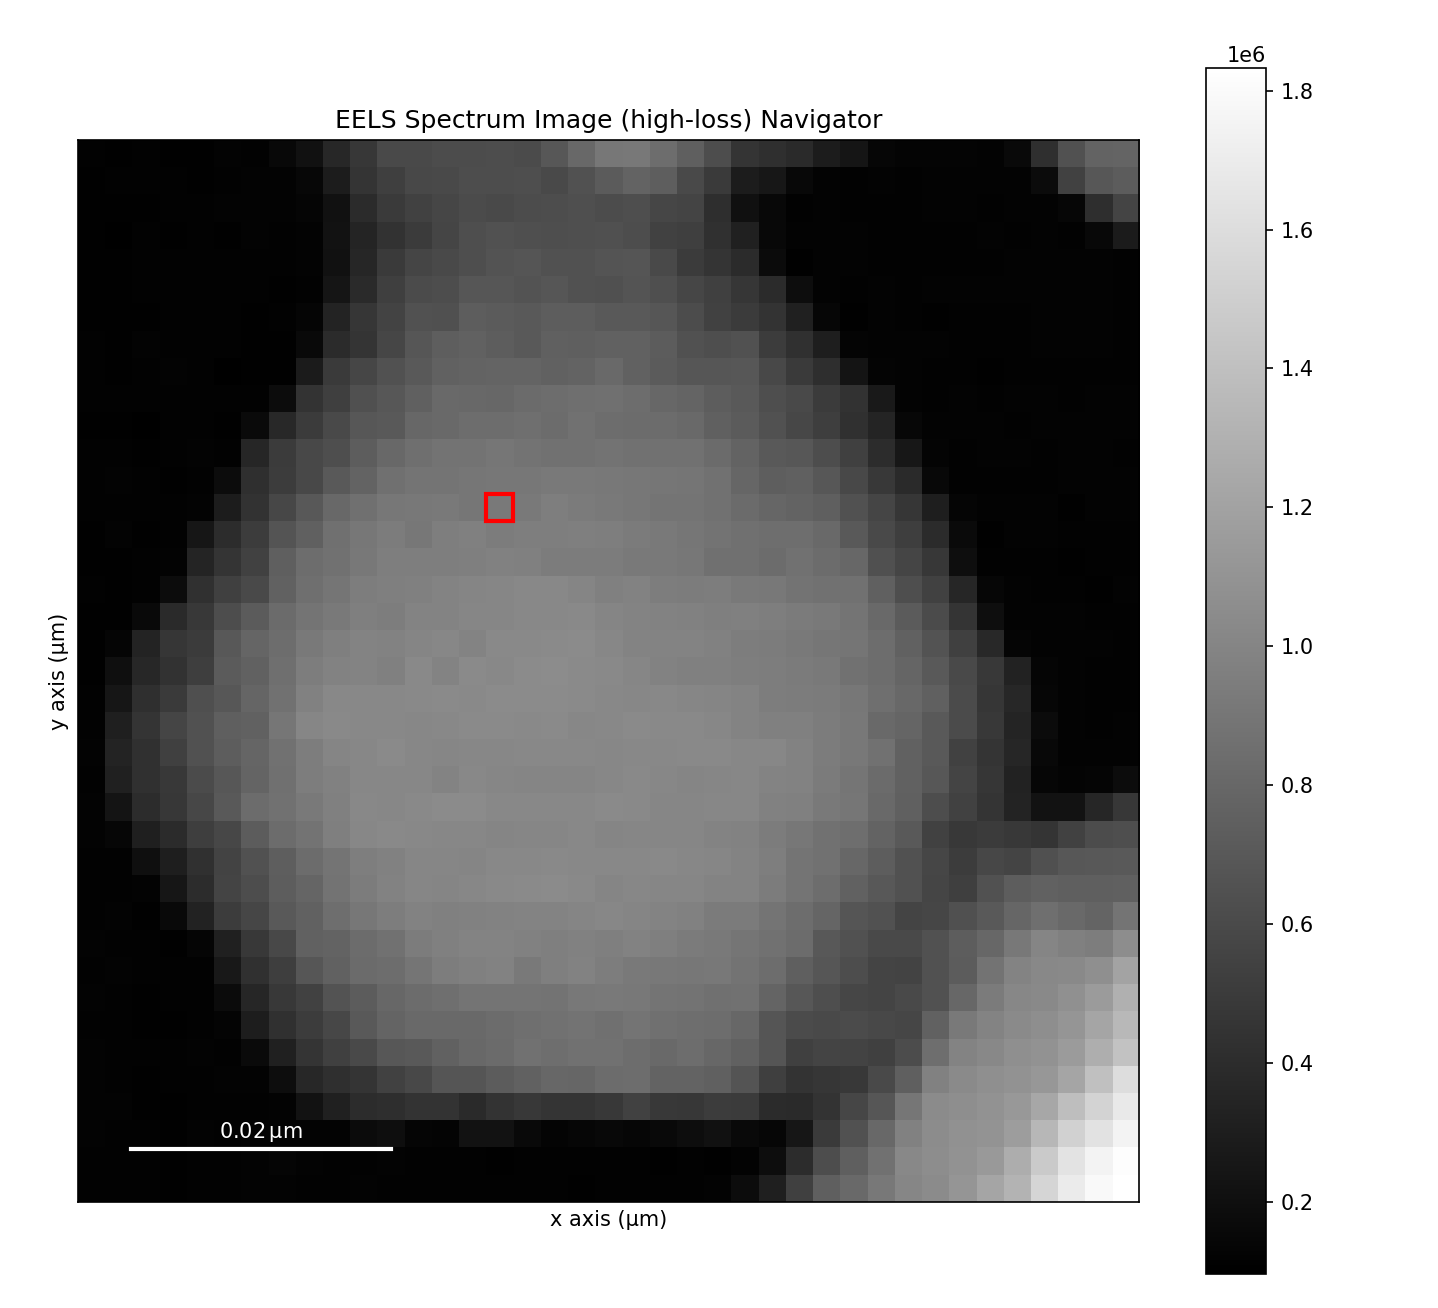

<IPython.core.display.Javascript object>


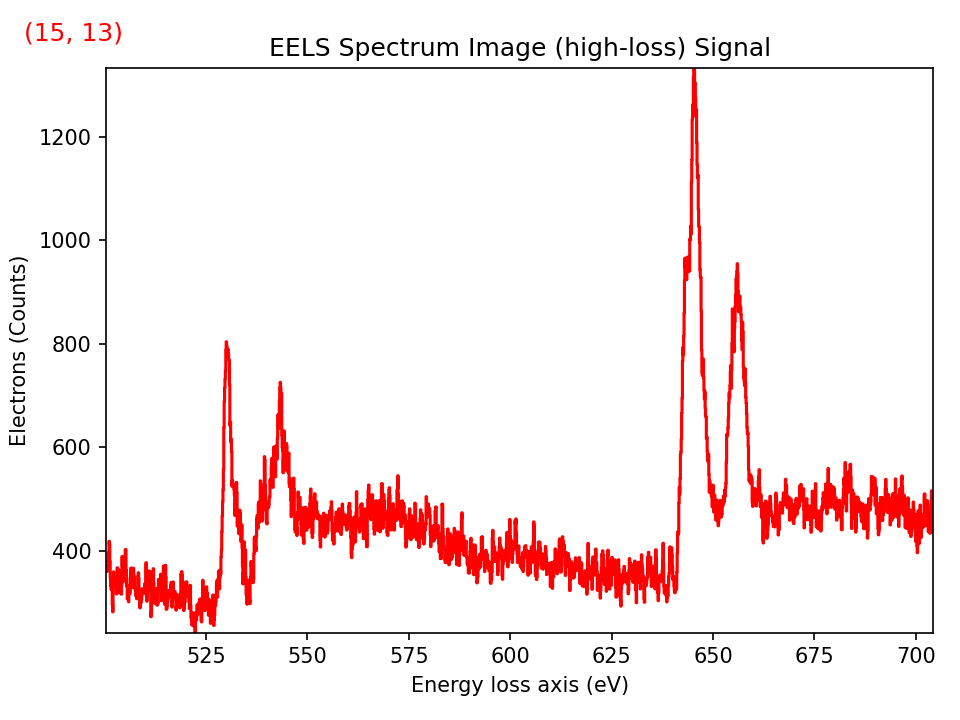

In [2]:
# Load dual EELS data, and align core loss peak based on zero loss peak

zl=hs.load('pristine_ll.dm4')
cl=hs.load('pristine_cl.dm4')

zl.align_zero_loss_peak(subpixel=True, also_align=[cl],signal_range=(-10.0,10.0))
cl.plot()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


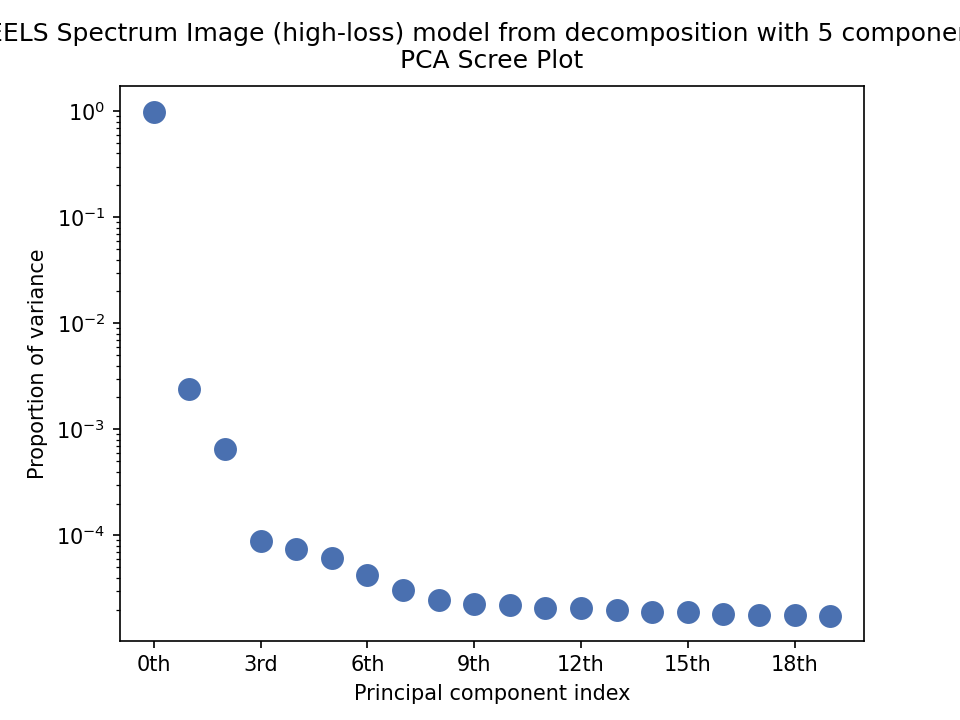

<IPython.core.display.Javascript object>


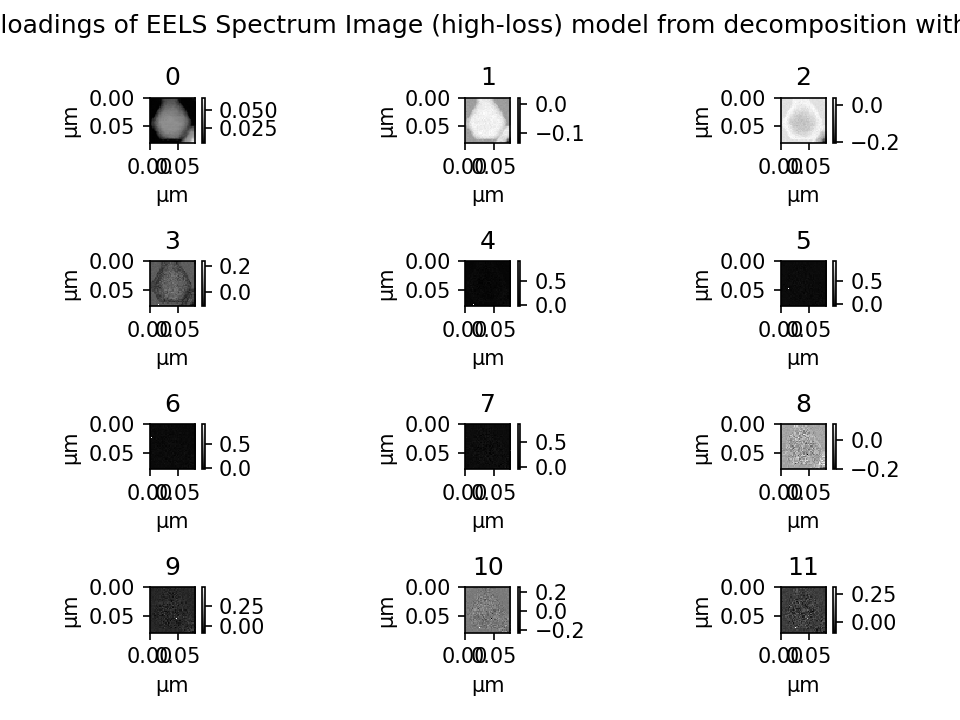

<IPython.core.display.Javascript object>


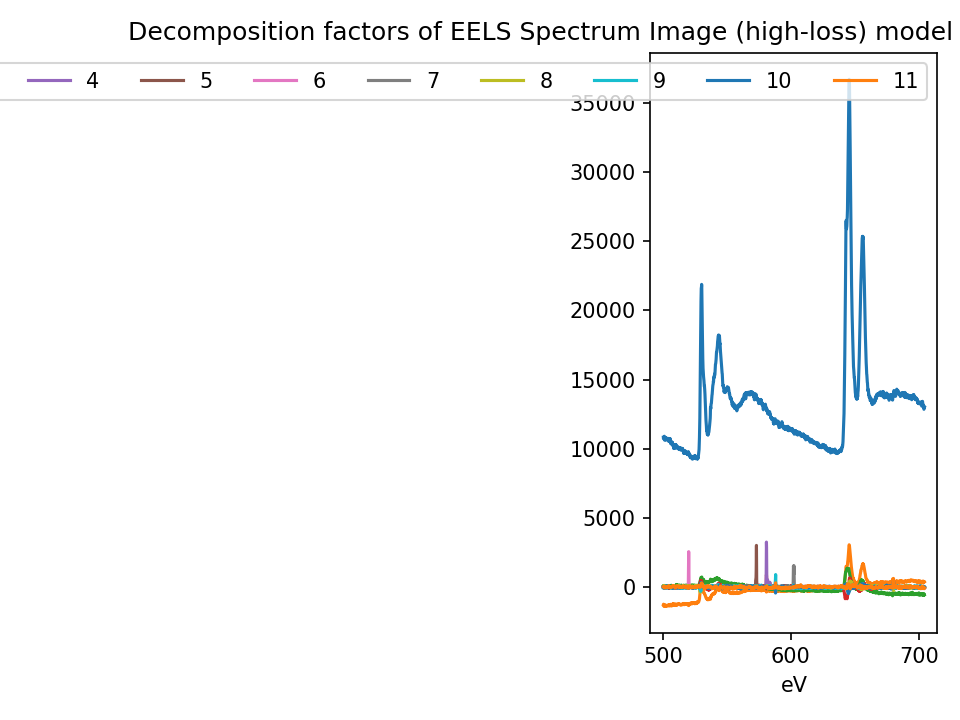

<IPython.core.display.Javascript object>


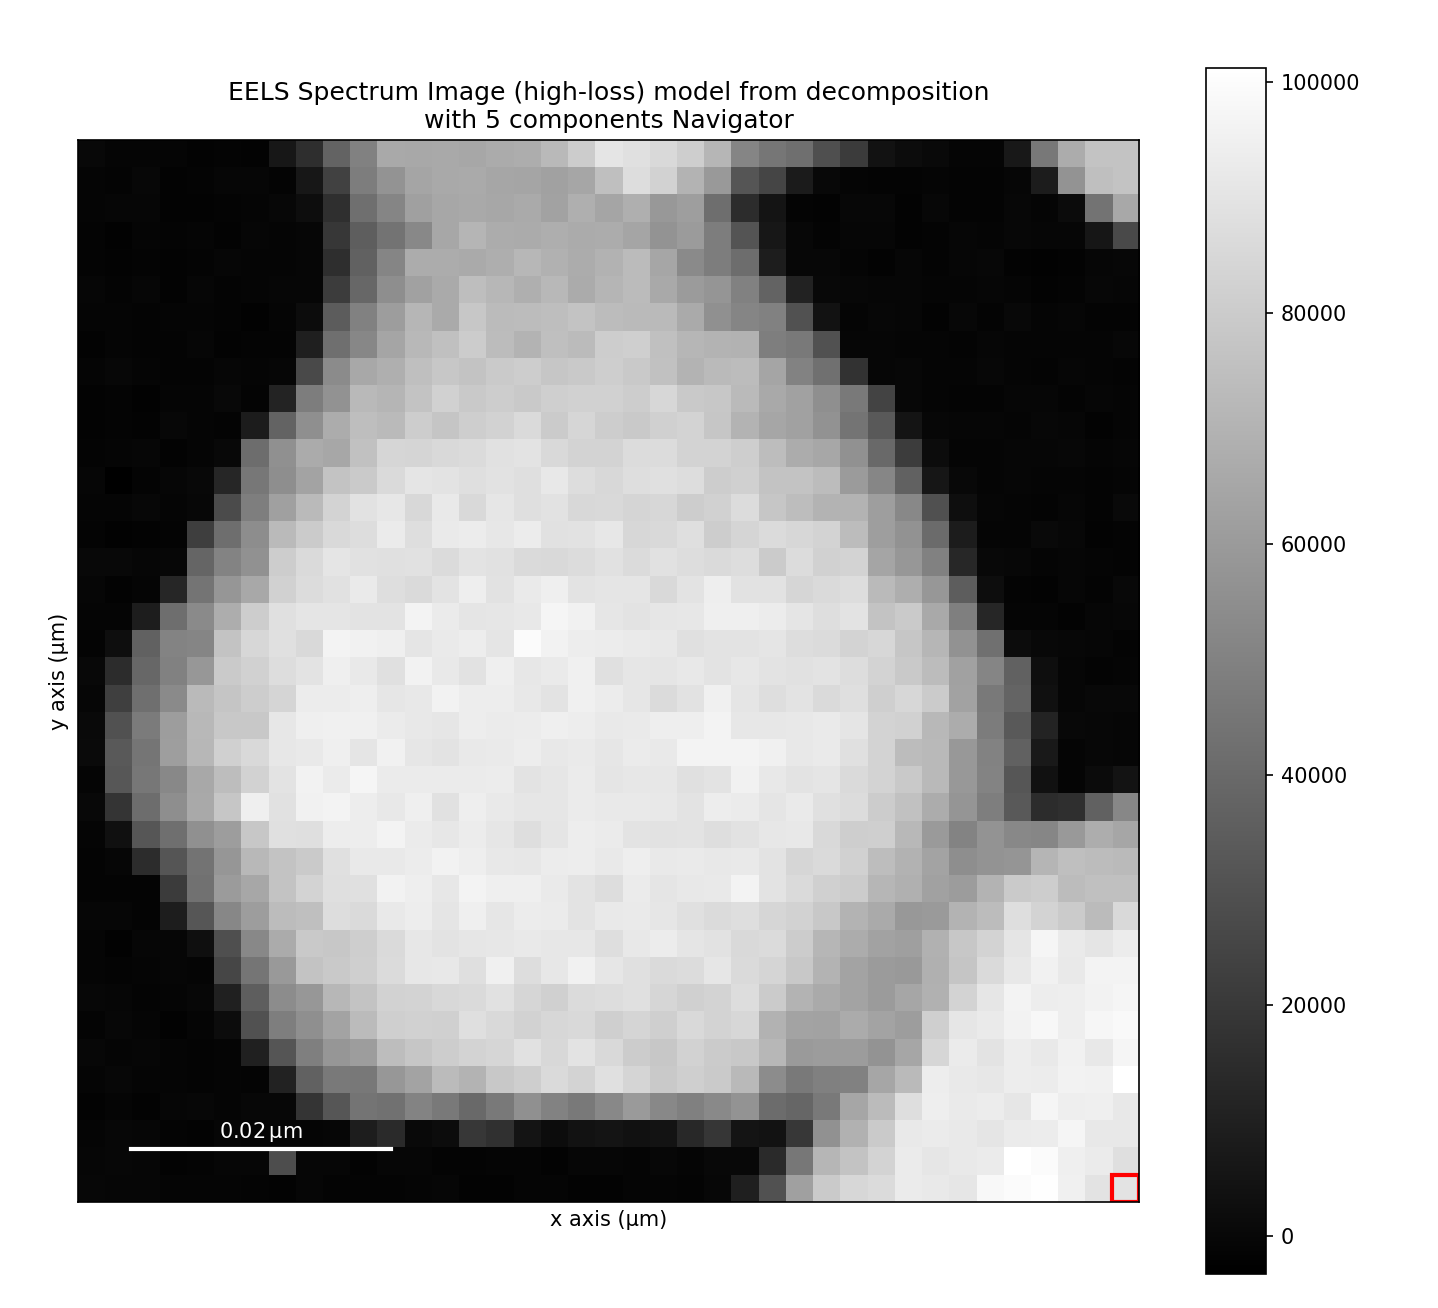

<IPython.core.display.Javascript object>


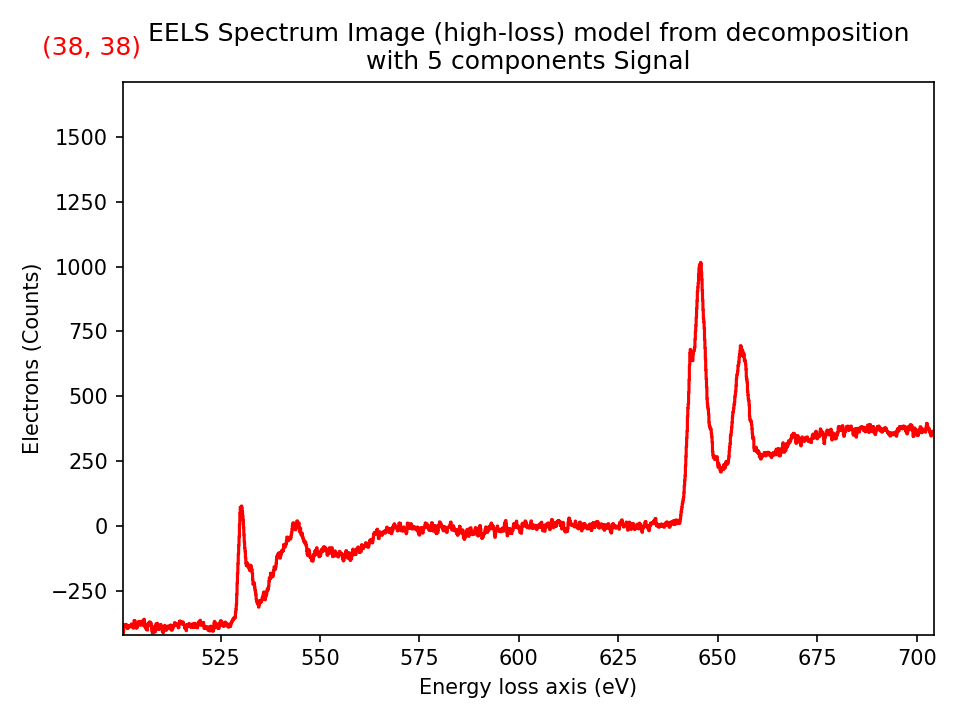

In [3]:
# Core loss EELS data denoise by using principal component analysis (PCA) method

cl.decomposition(normalize_poissonian_noise=False)
cldenoise=cl.get_decomposition_model(5)

cldenoise.plot_explained_variance_ratio(n=20)
cldenoise.plot_decomposition_loadings(12)
cldenoise.plot_decomposition_factors(12)
cldenoise.plot()

#### Curve Fitting Method

C:\Users\xiang\anaconda3\lib\site-packages\hyperspy\model.py:1890: VisibleDeprecationWarning: The `iterpath` default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change the 'iterpath' argument to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/1521 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


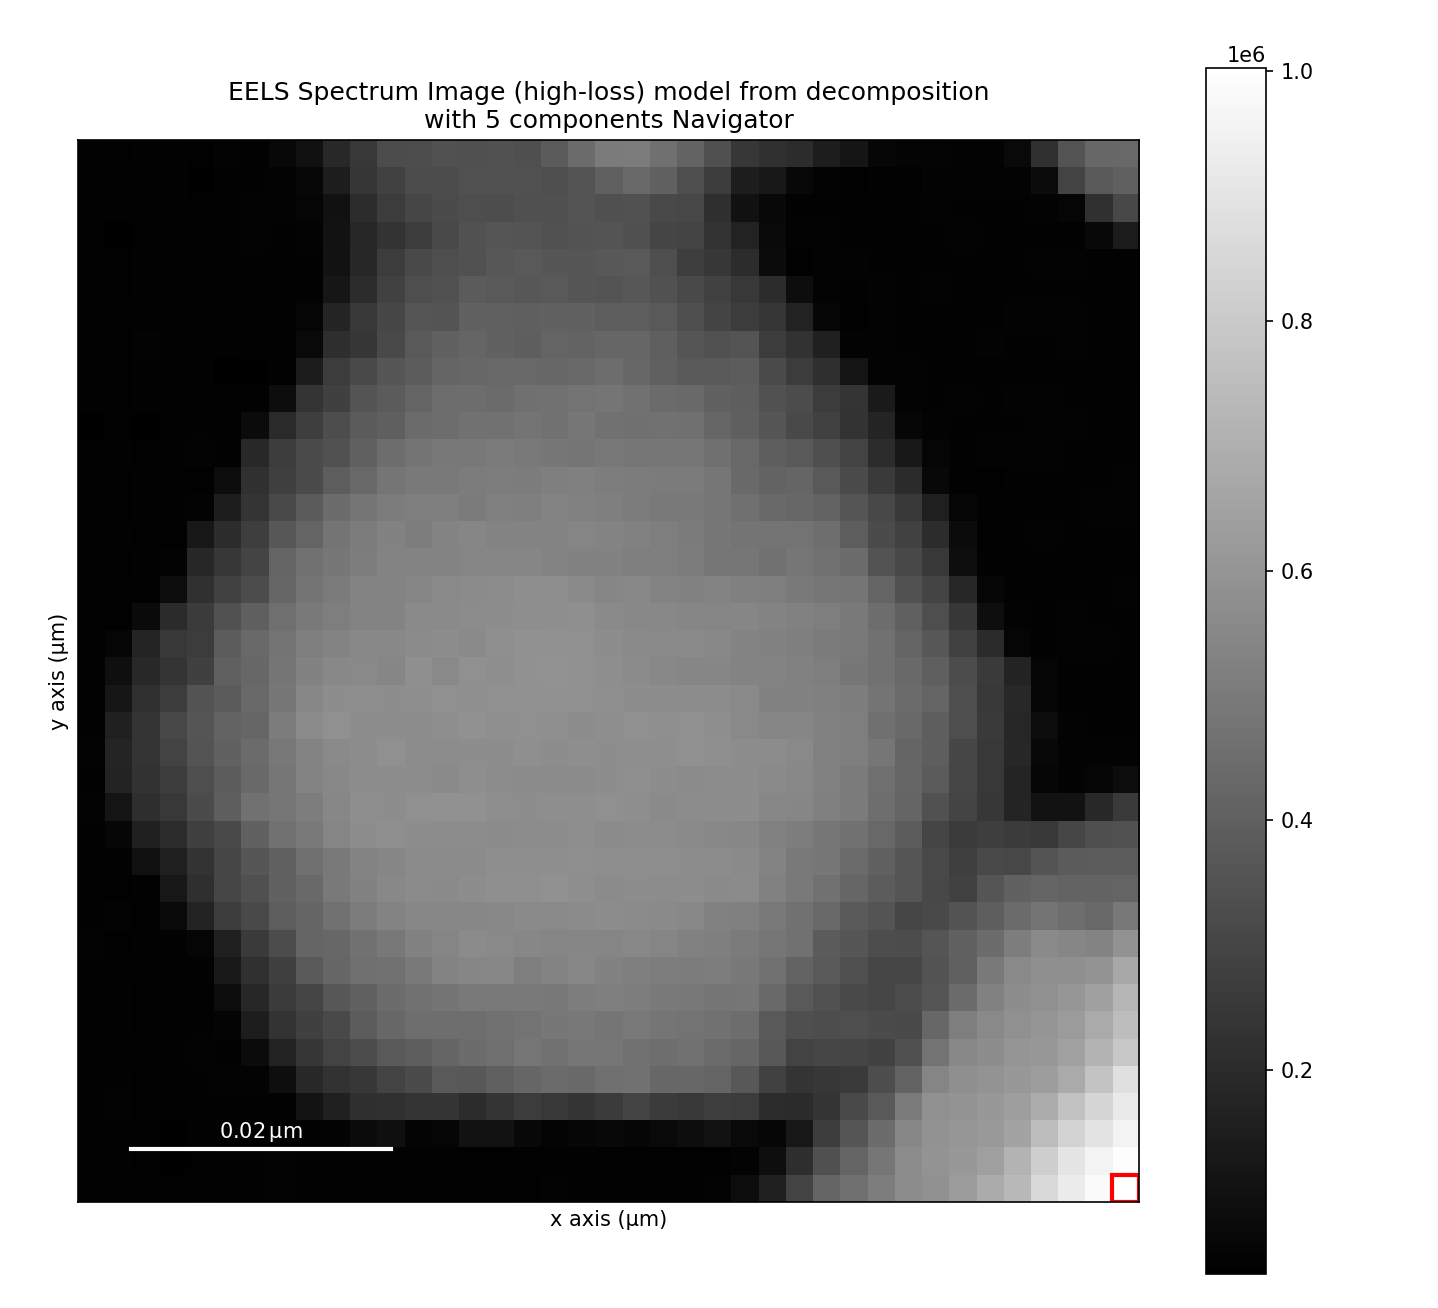

<IPython.core.display.Javascript object>


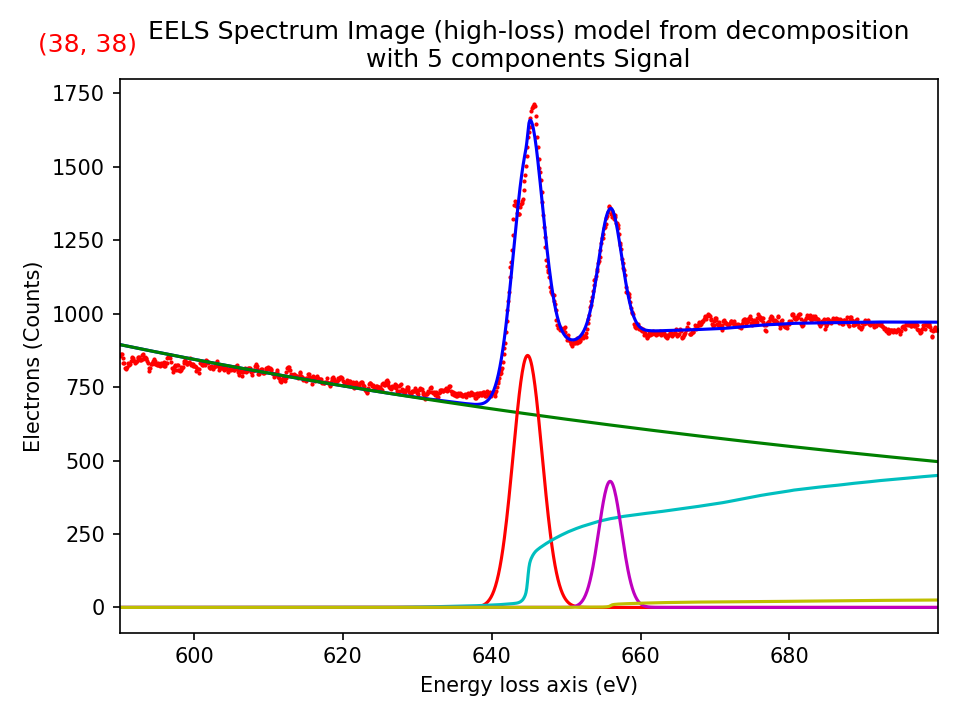

In [4]:
# Create a model that contains: 1. "PowerLaw" function for EELS background; 2. Gaussian fuction for Mn L3 peak; 3. Mn L3 CLEdge;
# 4. Gaussian function for Mn L2 peak; 5. Mn L2 CLEdge. Forward convolution of plural effect are applied to Mn L3 and L2 CLEdges. 

clMn=cldenoise.isig[590.0:700.0]

m1=clMn.create_model(ll=zl, GOS="Hartree-Slater", auto_add_edges=False)

m1.fit_component(m1["PowerLaw"], bounded=True, signal_range=[600.,633.], fit_independent=True, only_current=True)
m1.assign_current_values_to_all()

#Gaussian Mn_L3_white_line
gaussianMn_L3=hs.model.components1D.Gaussian()
gaussianMn_L3.name = 'Mn L3 white line'

gaussianMn_L3.A.bmin = 0.0
gaussianMn_L3.sigma.bmin = 0.0
gaussianMn_L3.sigma.bmax=3
gaussianMn_L3.centre.bmin = 640.0
gaussianMn_L3.centre.bmax = 650.0
gaussianMn_L3.convolved=False
m1.append(gaussianMn_L3)

m1.fit_component(gaussianMn_L3,optimizer="lm", signal_range=[gaussianMn_L3.centre.bmin-3.0, gaussianMn_L3.centre.bmax+3.0], bounded=True,fit_independent=True, only_current=True)
m1.assign_current_values_to_all([gaussianMn_L3])

#Mn L3 CLEdge
Mn_L3 = hs.model.components1D.EELSCLEdge("Mn_L3", GOS="Hartree-Slater")
m1.append(Mn_L3)

Mn_L3.onset_energy.free = True
Mn_L3.onset_energy.twin = gaussianMn_L3.centre
Mn_L3.onset_energy.value = 644.0
Mn_L3.onset_energy.bmin = 641.0
Mn_L3.onset_energy.bmax = 650.0
m1.fit_component(Mn_L3, bounded=True, signal_range=[638., 670.])
m1.assign_current_values_to_all([Mn_L3])

#Gaussian Mn_L2_white_line
gaussianMn_L2=hs.model.components1D.Gaussian()
gaussianMn_L2.name = 'Mn L2 white line'

gaussianMn_L2.A.bmin = 0.0
gaussianMn_L2.sigma.bmin=0.0
gaussianMn_L2.sigma.bmax=3
gaussianMn_L2.centre.bmin = 650.0
gaussianMn_L2.centre.bmax = 663.0
gaussianMn_L2.convolved=False
m1.append(gaussianMn_L2)

m1.fit_component(gaussianMn_L2, optimizer="lm", signal_range=[gaussianMn_L2.centre.bmin-3.0, gaussianMn_L2.centre.bmax+3.0], bounded=True,fit_independent=True, only_current=True)
m1.assign_current_values_to_all([gaussianMn_L2])

#Mn L2 CLEdge
Mn_L2 = hs.model.components1D.EELSCLEdge("Mn_L2", GOS="Hartree-Slater")
m1.append(Mn_L2)

Mn_L2.onset_energy.free = True
Mn_L2.onset_energy.twin = gaussianMn_L2.centre
Mn_L2.onset_energy.value = 656.0
Mn_L2.onset_energy.bmin = 650.0
Mn_L2.onset_energy.bmax = 660.0
m1.fit_component(Mn_L2, bounded=True, signal_range=[650., 670.])
m1.assign_current_values_to_all([Mn_L2])

m1.components
m1.multifit(bounded=True)
m1.plot(True)

In [5]:
# Calculate the white line ratio by using GaussianAmplitude L3/GaussianAmplitude L2.

mnl3_amp=np.array(m1[1].A.as_signal())
mnl2_amp=np.array(m1[3].A.as_signal())
m1.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |    Mn_L3_white_line |    Mn L3 white line |            Gaussian
   2 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   3 |    Mn_L2_white_line |    Mn L2 white line |            Gaussian
   4 |               Mn_L2 |               Mn_L2 |          EELSCLEdge

In [6]:
# Export the white line ratio

wlr2=pd.DataFrame(mnl3_amp/mnl2_amp)
wlr2.to_csv("pristine_wlr_CFM.csv")

C:\Users\xiang\AppData\Local\Temp/ipykernel_13124/359738594.py:3: RuntimeWarning: divide by zero encountered in true_divide
  wlr2=pd.DataFrame(mnl3_amp/mnl2_amp)
C:\Users\xiang\AppData\Local\Temp/ipykernel_13124/359738594.py:3: RuntimeWarning: invalid value encountered in true_divide
  wlr2=pd.DataFrame(mnl3_amp/mnl2_amp)


#### Pearson Method

In [7]:
# To apply Pearson Method, it is necessary to first run the codes of curve fitting method to determine curve center.

# Remove background by using "PowerLaw" function. 
# 1. Select the pre-edge window as [600., 630.] eV. The selection of pre-edge window is done by manually selecting the window in the EELS spectrum in cell [3]. 
# 2. Unselect "Fast" mode.

cldenoise.remove_background()

  0%|          | 0/1521 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


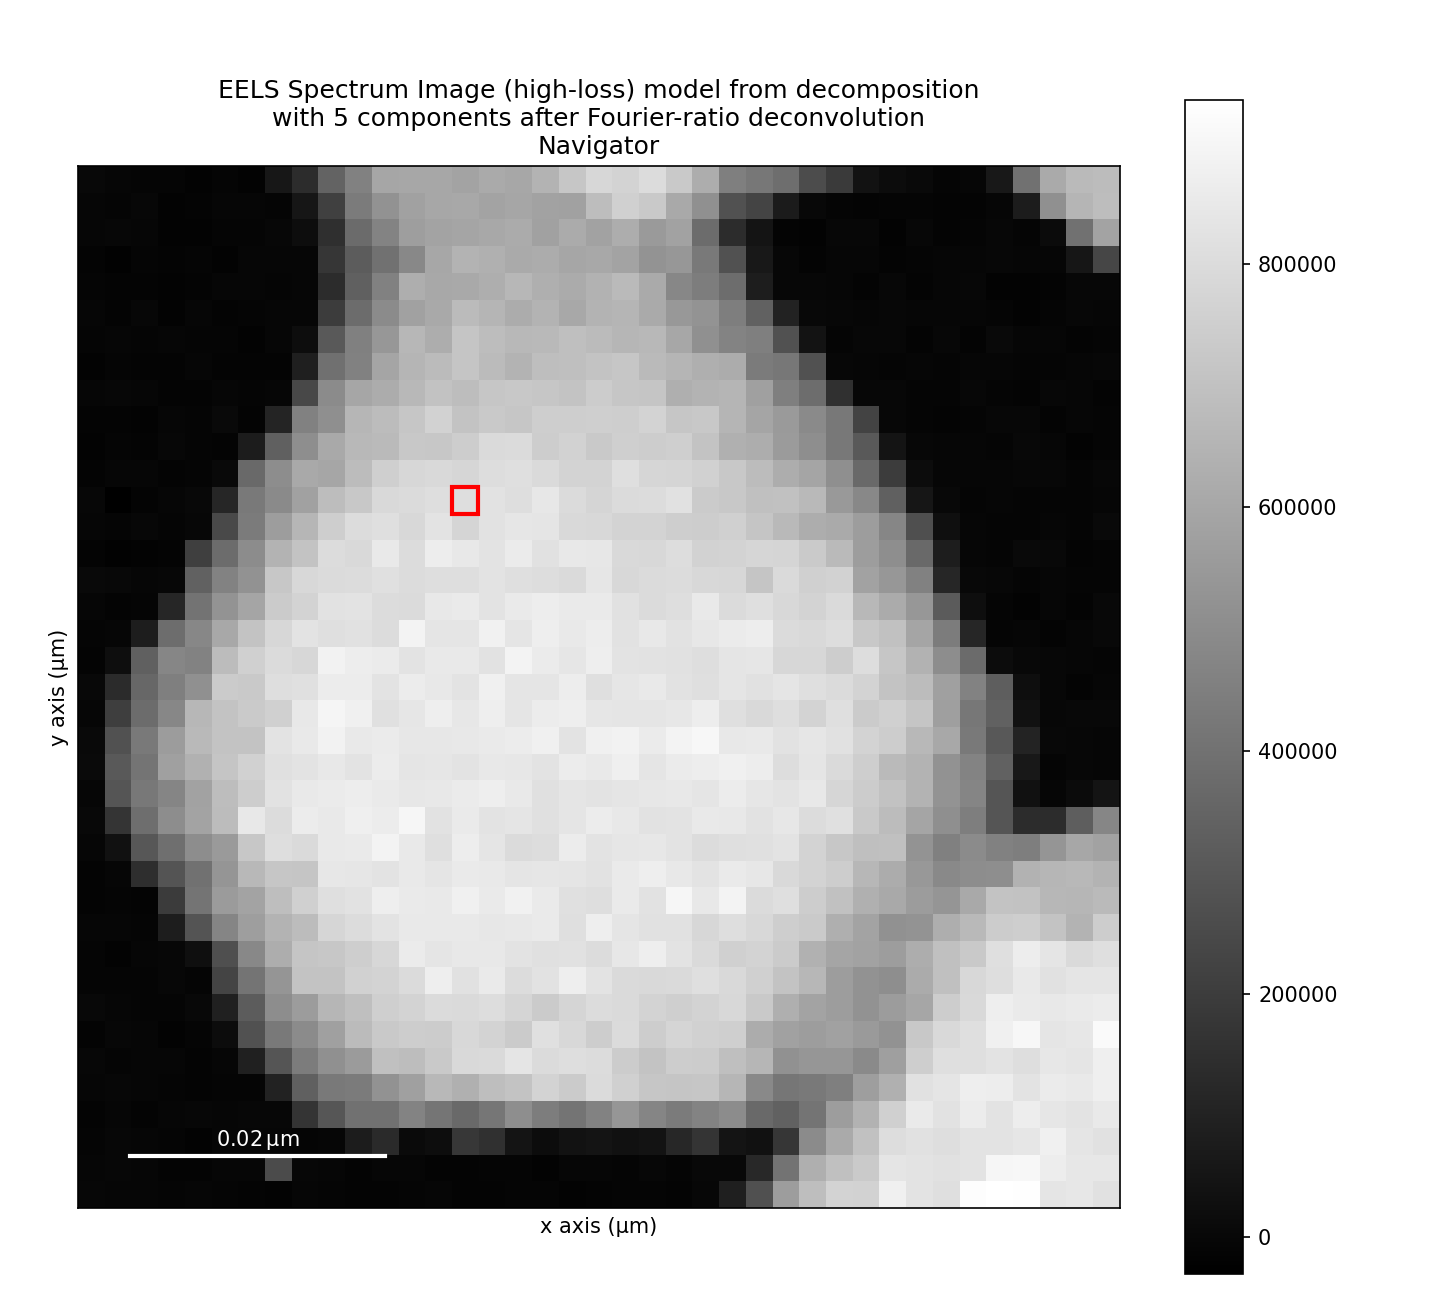

<IPython.core.display.Javascript object>


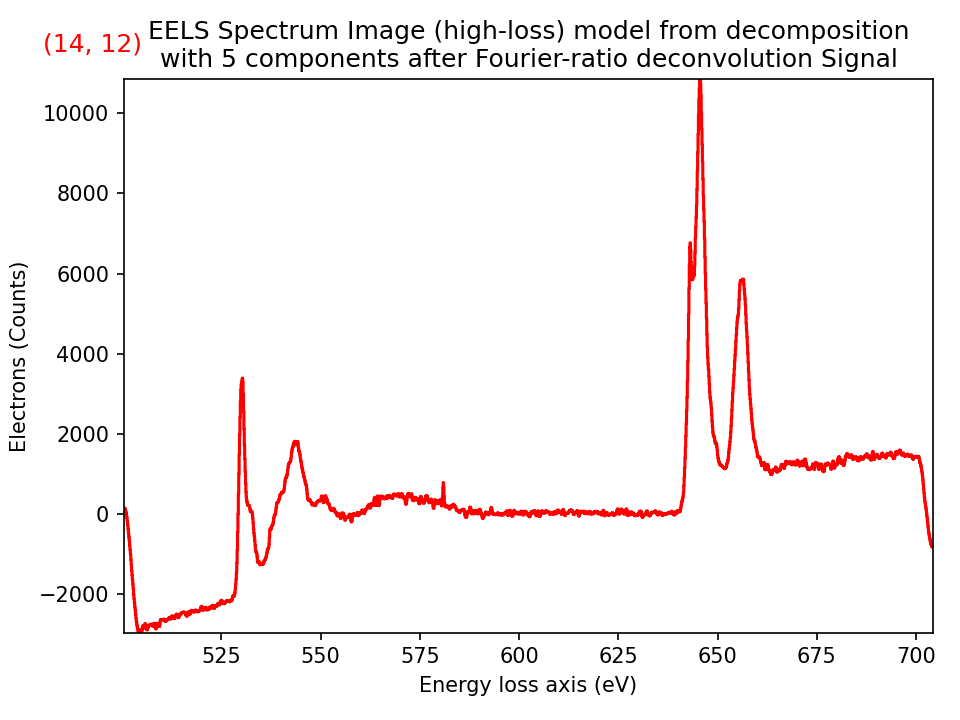

In [8]:
# Remove the effect of plural scattering by using "Fourier Ratio Deconvolution" function

cldeconv=cldenoise.fourier_ratio_deconvolution(zl,extrapolate_coreloss=False, extrapolate_lowloss=False)
cldeconv.plot()

In [11]:
# Step position is equal to Gaussian center.

mn_L3_center=np.array(m1[1].centre.as_signal())
mn_L2_center=np.array(m1[3].centre.as_signal())
mn_L3_sigma=np.array(m1[1].sigma.as_signal())
mn_L2_sigma=np.array(m1[3].sigma.as_signal())

m1.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |    Mn_L3_white_line |    Mn L3 white line |            Gaussian
   2 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   3 |    Mn_L2_white_line |    Mn L2 white line |            Gaussian
   4 |               Mn_L2 |               Mn_L2 |          EELSCLEdge

In [12]:
# Calculate white line ratio

row = mn_L3_sigma.shape[0] # row of core loss EELS data
col = mn_L3_sigma.shape[1] # column of core loss EELS data

ratio = np.zeros((row,col)) #(row,column)

win3=10.0 # integration window of Mn L3
win2=8.0 # integration window of Mn L2

backg=np.array(cldeconv.isig[670.0:690.0].integrate1D(axis="Energy loss")/20) 
# Average 20 eV signal range beyond L2 edge to extrapolate a horizontal line. 
#Change of signal range can slightly change the absolute value of white line ratio.

for col in range (col): 
    for row in range (row): 
        l3p = mn_L3_center[row, col] # center of the step L3
        l2p = l3p + 10.6 # center of the step L2

        mnl3 = np.array(cldeconv.inav[col, row].isig[(l3p-win3/2):(l3p+win3/2)].integrate1D(axis="Energy loss"))-backg[row, col]*(2/3)*(win3/2)
        mnl2 = np.array(cldeconv.inav[col, row].isig[(l2p-win2/2):(l2p+win2/2)].integrate1D(axis="Energy loss"))-backg[row, col]*(5/3)*(win2/2)
        # integrate the L3, L2 peak and subtracte the step function underneath it.
        ratio[row][col]=np.divide(mnl3.data[0],mnl2.data[0])
        row=row+1
    col=col+1       
        
wlr=pd.DataFrame(ratio)

In [13]:
# Export the white line ratio

wlr=pd.DataFrame(ratio)
wlr.to_csv("Pristine_wlr_.csv")